## GPU 메모리 관리

**GPU 메모리가 부족할 때:**
1. `GPU_Memory_Manager.ipynb` 노트북을 열어서
2. 첫 번째 코드 셀(함수 정의)을 이 노트북에 복사해서 실행
3. 그 다음 `clear_gpu_memory()` 또는 `print_gpu_memory()` 사용

**빠른 정리:**
```python
import torch, gc
gc.collect()
torch.cuda.empty_cache()
```

## GPU 메모리 관리

GPU 메모리가 부족할 때 사용하세요:

```python
from gpu_memory_utils import clear_gpu_memory, print_gpu_memory

# GPU 메모리 상태 확인
print_gpu_memory()

# GPU 메모리 정리
clear_gpu_memory()
```

In [1]:
from notebooks.gpu_memory_utils import clear_gpu_memory, print_gpu_memory

# GPU 메모리 상태 확인'
print_gpu_memory()

# GPU 메모리 정리
clear_gpu_memory()

GPU 0: NVIDIA GeForce RTX 2060
Total Memory:     5730.12 MB
Allocated:        0.00 MB (0.0%)
Reserved:         0.00 MB (0.0%)
Free:             5730.12 MB (100.0%)
GPU Memory Cleanup
Before cleanup:
  Allocated: 0.00 MB
  Reserved:  0.00 MB

After cleanup:
  Allocated: 0.00 MB (freed: 0.00 MB)
  Reserved:  0.00 MB (freed: 0.00 MB)


{'before': {'allocated': 0.0, 'reserved': 0.0},
 'after': {'allocated': 0.0, 'reserved': 0.0},
 'freed': {'allocated': 0.0, 'reserved': 0.0}}

## 1. 환경 설정

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import time

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# GPU 메모리 정리
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")

Using device: cuda
GPU: NVIDIA GeForce RTX 2060
GPU memory allocated: 0.00 MB
GPU memory reserved: 0.00 MB


## 2. 하이퍼파라미터

In [3]:
# 하이퍼파라미터
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001
IMG_SIZE = 224

# 경로 (새로운 데이터셋 구조)
DATA_DIR = './data/dataset_20251110_141636/beverage'  # Label Studio에서 변환된 데이터
MODEL_SAVE_PATH = './models/weights/beverage_detector.pth'

# Train/Val 분할 비율
TRAIN_SPLIT = 0.8

# 클래스 설정 (unclear 포함 여부 선택)
INCLUDE_UNCLEAR = True  # unclear 클래스를 학습에 포함할지 여부

if INCLUDE_UNCLEAR:
    CLASS_NAMES = ['empty', 'with_beverage', 'unclear']
    NUM_CLASSES = 3
else:
    CLASS_NAMES = ['empty', 'with_beverage']
    NUM_CLASSES = 2

print(f"Dataset directory: {DATA_DIR}")
print(f"Model will be saved to: {MODEL_SAVE_PATH}")
print(f"Classes: {CLASS_NAMES} ({NUM_CLASSES} classes)")

Dataset directory: ./data/dataset_20251110_141636/beverage
Model will be saved to: ./models/weights/beverage_detector.pth
Classes: ['empty', 'with_beverage', 'unclear'] (3 classes)


## 3. 데이터 전처리

In [4]:
# 학습용 Transform
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # 음료 색상 다양성
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증용 Transform
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 4. 데이터셋 클래스

In [5]:
from sklearn.model_selection import train_test_split

class BeverageDataset(Dataset):
    """음료 포함 여부 데이터셋 (크롭된 container 이미지)"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        print(f"Loaded {len(self.image_paths)} images")
        unique, counts = np.unique(labels, return_counts=True)
        for cls, count in zip(unique, counts):
            print(f"  - {CLASS_NAMES[cls]}: {count}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def load_dataset_from_directory(data_dir, class_names):
    """디렉토리에서 데이터셋 로드 및 Train/Val 분할"""
    all_images = []
    all_labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found, skipping...")
            continue
        
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img_name)
                all_images.append(img_path)
                all_labels.append(class_idx)
    
    print(f"\nTotal images loaded: {len(all_images)}")
    print(f"Class distribution:")
    unique, counts = np.unique(all_labels, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  - {class_names[cls]}: {count} ({count/len(all_labels)*100:.1f}%)")
    
    # Train/Val 분할 (stratified)
    train_images, val_images, train_labels, val_labels = train_test_split(
        all_images, all_labels, 
        test_size=1-TRAIN_SPLIT, 
        stratify=all_labels,
        random_state=42
    )
    
    print(f"\nSplit: {len(train_images)} train, {len(val_images)} val")
    
    return train_images, val_images, train_labels, val_labels

## 5. 데이터 로더

In [6]:
# 데이터 로드 및 분할
train_images, val_images, train_labels, val_labels = load_dataset_from_directory(DATA_DIR, CLASS_NAMES)

# 데이터셋 생성
train_dataset = BeverageDataset(train_images, train_labels, transform=train_transform)
val_dataset = BeverageDataset(val_images, val_labels, transform=val_transform)

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Total images loaded: 220
Class distribution:
  - empty: 150 (68.2%)
  - with_beverage: 42 (19.1%)
  - unclear: 28 (12.7%)

Split: 176 train, 44 val
Loaded 176 images
  - empty: 120
  - with_beverage: 34
  - unclear: 22
Loaded 44 images
  - empty: 30
  - with_beverage: 8
  - unclear: 6

Train batches: 6
Val batches: 2


## 6. 샘플 이미지 확인

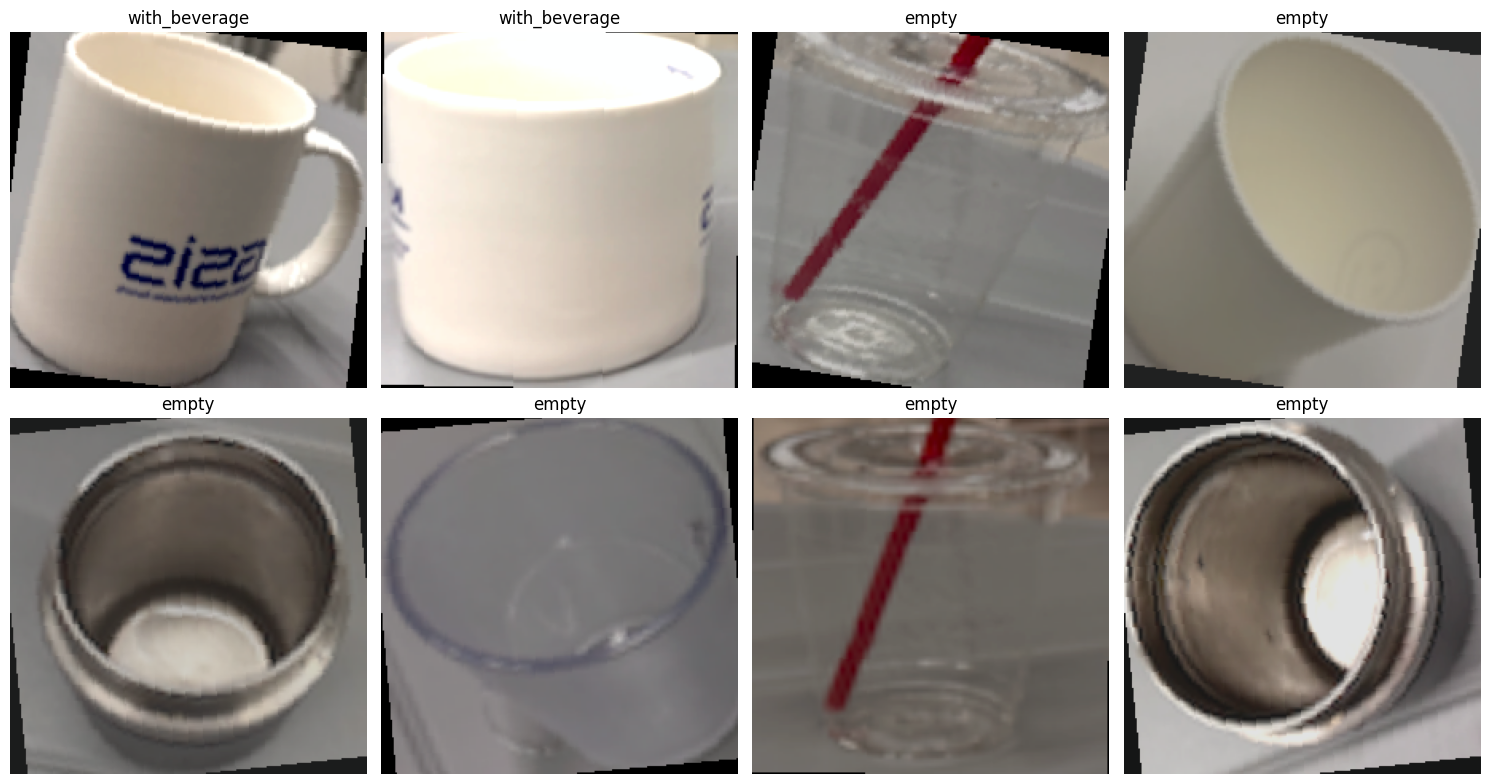

In [7]:
def show_samples(loader, num_samples=8):
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(CLASS_NAMES[labels[i]])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(train_loader)

## 7. 경량 모델 정의

In [8]:
class BeverageDetector(nn.Module):
    """MobileNetV3-Small 기반 음료 검증 모델"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(BeverageDetector, self).__init__()
        
        # MobileNetV3-Small 백본 (경량화)
        self.backbone = models.mobilenet_v3_small(pretrained=pretrained)
        
        # 분류 헤드 교체
        num_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.Hardswish(),  # MobileNetV3에 최적화된 활성화 함수
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# GPU 메모리가 부족한 경우를 대비한 처리
try:
    # 먼저 GPU 메모리 정리
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        free_memory = (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1024**2
        print(f"Available GPU memory: {free_memory:.2f} MB")

    # 모델 생성
    model = BeverageDetector(num_classes=NUM_CLASSES, pretrained=True)
    model = model.to(device)

    # 학습 시에는 float32 사용 (안정성)
    # 추론 시에만 float16 사용
    print(f"✓ Model loaded successfully on {device}")
    print(f"✓ Using float32 for training (more stable)")

    if device.type == 'cuda':
        print(f"GPU memory after loading: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"\n✓ Lightweight model for fast inference")

except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print(f"⚠ GPU out of memory. Falling back to CPU...")
        device = torch.device('cpu')
        torch.cuda.empty_cache()

        model = BeverageDetector(num_classes=NUM_CLASSES, pretrained=True)
        model = model.to(device)

        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"✓ Model loaded on CPU (slower but works)")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
    else:
        raise

Available GPU memory: 5730.12 MB


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 20.3MB/s]


✓ Model loaded successfully on cuda
✓ Using float32 for training (more stable)
GPU memory after loading: 4.21 MB
Total parameters: 1,075,491
Trainable parameters: 1,075,491

✓ Lightweight model for fast inference


## 8. 손실 함수 및 옵티마이저

In [9]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저 (Adam)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

## 9. 학습 및 평가 함수

In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    return running_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / len(loader), 100 * accuracy_score(all_labels, all_preds), all_preds, all_labels

## 10. 학습 실행

In [11]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 50)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✓ Best model saved (Val Acc: {val_acc:.2f}%)")

print(f"\n{'='*50}")
print(f"Training completed! Best Val Acc: {best_val_acc:.2f}%")


Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 15.37it/s]


Train Loss: 0.8199, Train Acc: 61.36%
Val Loss: 0.6541, Val Acc: 70.45%
✓ Best model saved (Val Acc: 70.45%)

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.05it/s]


Train Loss: 0.4100, Train Acc: 86.93%
Val Loss: 1.0077, Val Acc: 77.27%
✓ Best model saved (Val Acc: 77.27%)

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 19.83it/s]


Train Loss: 0.2117, Train Acc: 94.32%
Val Loss: 1.7058, Val Acc: 77.27%

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.82it/s]


Train Loss: 0.1593, Train Acc: 93.75%
Val Loss: 1.6841, Val Acc: 86.36%
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
✓ Best model saved (Val Acc: 86.36%)

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.39it/s]


Train Loss: 0.0904, Train Acc: 97.16%
Val Loss: 1.3590, Val Acc: 84.09%

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.55it/s]


Train Loss: 0.1100, Train Acc: 95.45%
Val Loss: 1.1327, Val Acc: 81.82%

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.86it/s]


Train Loss: 0.0921, Train Acc: 97.16%
Val Loss: 1.0480, Val Acc: 79.55%
Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.87it/s]


Train Loss: 0.0776, Train Acc: 97.73%
Val Loss: 0.9614, Val Acc: 81.82%

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.80it/s]


Train Loss: 0.0783, Train Acc: 97.16%
Val Loss: 0.8848, Val Acc: 77.27%

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.35it/s]


Train Loss: 0.0552, Train Acc: 97.73%
Val Loss: 0.7758, Val Acc: 86.36%
Epoch 00010: reducing learning rate of group 0 to 1.2500e-04.

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.58it/s]


Train Loss: 0.0414, Train Acc: 99.43%
Val Loss: 0.6783, Val Acc: 88.64%
✓ Best model saved (Val Acc: 88.64%)

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.78it/s]


Train Loss: 0.0306, Train Acc: 99.43%
Val Loss: 0.6010, Val Acc: 93.18%
✓ Best model saved (Val Acc: 93.18%)

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.87it/s]


Train Loss: 0.0397, Train Acc: 99.43%
Val Loss: 0.5456, Val Acc: 93.18%

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.44it/s]


Train Loss: 0.0347, Train Acc: 98.86%
Val Loss: 0.5066, Val Acc: 93.18%

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.17it/s]


Train Loss: 0.0262, Train Acc: 99.43%
Val Loss: 0.4725, Val Acc: 93.18%

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.57it/s]


Train Loss: 0.0296, Train Acc: 100.00%
Val Loss: 0.4392, Val Acc: 93.18%

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.80it/s]


Train Loss: 0.0306, Train Acc: 99.43%
Val Loss: 0.4025, Val Acc: 93.18%

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.84it/s]


Train Loss: 0.0278, Train Acc: 99.43%
Val Loss: 0.4043, Val Acc: 93.18%

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.68it/s]


Train Loss: 0.0170, Train Acc: 100.00%
Val Loss: 0.4249, Val Acc: 93.18%

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.08it/s]


Train Loss: 0.0097, Train Acc: 100.00%
Val Loss: 0.4324, Val Acc: 93.18%
Epoch 00020: reducing learning rate of group 0 to 6.2500e-05.

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.04it/s]


Train Loss: 0.0121, Train Acc: 100.00%
Val Loss: 0.4118, Val Acc: 93.18%

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.61it/s]


Train Loss: 0.0553, Train Acc: 99.43%
Val Loss: 0.3902, Val Acc: 93.18%

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.56it/s]


Train Loss: 0.0089, Train Acc: 100.00%
Val Loss: 0.3693, Val Acc: 93.18%

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.48it/s]


Train Loss: 0.0195, Train Acc: 99.43%
Val Loss: 0.3514, Val Acc: 93.18%

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.76it/s]


Train Loss: 0.0097, Train Acc: 100.00%
Val Loss: 0.3354, Val Acc: 93.18%

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 18.78it/s]


Train Loss: 0.0089, Train Acc: 100.00%
Val Loss: 0.3243, Val Acc: 93.18%

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.10it/s]


Train Loss: 0.0418, Train Acc: 97.16%
Val Loss: 0.3136, Val Acc: 93.18%

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 17.99it/s]


Train Loss: 0.0095, Train Acc: 100.00%
Val Loss: 0.2802, Val Acc: 93.18%

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.49it/s]


Train Loss: 0.0108, Train Acc: 100.00%
Val Loss: 0.2597, Val Acc: 93.18%

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.17it/s]

Train Loss: 0.0317, Train Acc: 98.30%
Val Loss: 0.2446, Val Acc: 90.91%

Training completed! Best Val Acc: 93.18%


## 11. 학습 곡선

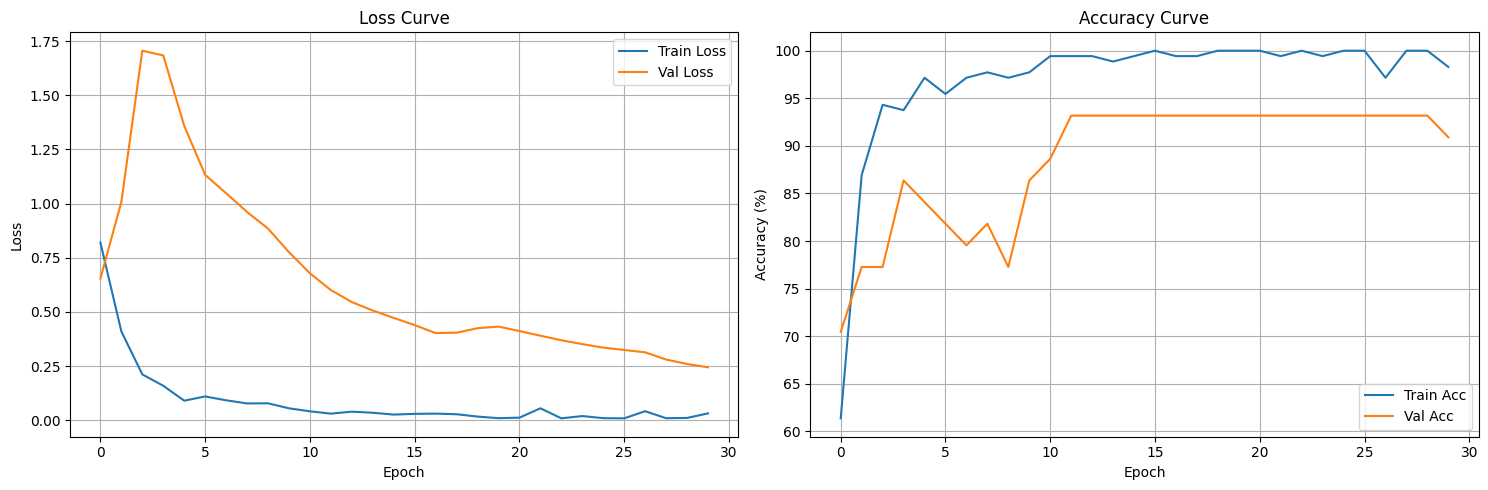

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Curve')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 12. 최종 평가

Validation: 100%|██████████| 2/2 [00:00<00:00, 19.32it/s]


Final Validation Accuracy: 93.18%
Final Validation Loss: 0.6010


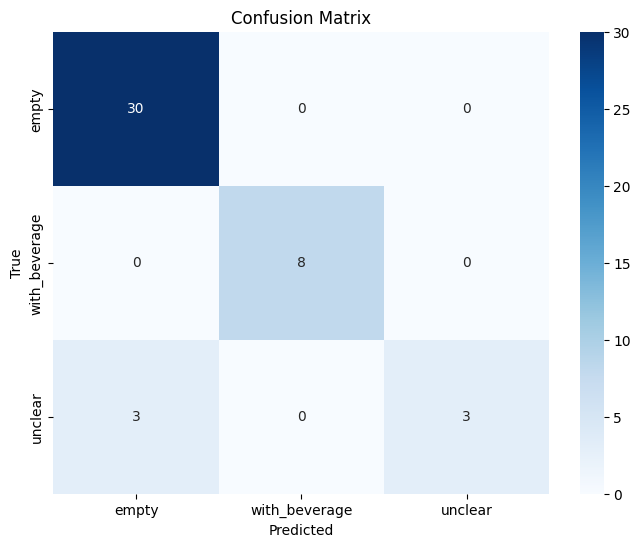


Classification Report:
               precision    recall  f1-score   support

        empty       0.91      1.00      0.95        30
with_beverage       1.00      1.00      1.00         8
      unclear       1.00      0.50      0.67         6

     accuracy                           0.93        44
    macro avg       0.97      0.83      0.87        44
 weighted avg       0.94      0.93      0.92        44



In [13]:
# 최고 모델 로드
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

val_loss, val_acc, preds, labels = validate(model, val_loader, criterion, device)

print(f"Final Validation Accuracy: {val_acc:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

# Confusion Matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=CLASS_NAMES))

## 13. 추론 속도 벤치마크

In [14]:
# 추론 속도 측정
model.eval()
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

# Warm-up
for _ in range(10):
    with torch.no_grad():
        _ = model(dummy_input)

# 벤치마크
num_runs = 100
start_time = time.time()

with torch.no_grad():
    for _ in range(num_runs):
        _ = model(dummy_input)

if device.type == 'cuda':
    torch.cuda.synchronize()

end_time = time.time()
avg_time = (end_time - start_time) / num_runs * 1000  # ms

print(f"Inference Speed:")
print(f"  Average time: {avg_time:.2f} ms")
print(f"  Throughput: {1000/avg_time:.1f} images/sec")
print(f"\n{'✓' if avg_time < 100 else '✗'} Target < 100ms: {'Achieved' if avg_time < 100 else 'Not achieved'}")

Inference Speed:
  Average time: 5.06 ms
  Throughput: 197.7 images/sec

✓ Target < 100ms: Achieved


## 14. 추론 함수

In [15]:
def detect_beverage(model, image_path, transform, device):
    """
    이미지에서 음료 포함 여부 검증
    
    Args:
        model: 학습된 모델
        image_path: 이미지 경로
        transform: 전처리 transform
        device: 디바이스
    
    Returns:
        dict: {'has_beverage': bool, 'confidence': float}
    """
    model.eval()
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    # with_beverage 클래스 확인 (클래스 인덱스가 1)
    has_beverage = CLASS_NAMES[predicted.item()] == 'with_beverage'
    confidence_score = confidence.item()
    
    return {
        'has_beverage': has_beverage,
        'confidence': confidence_score,
        'class': CLASS_NAMES[predicted.item()],
        'probabilities': probabilities.cpu().numpy()[0]
    }

def visualize_detection(image_path, result):
    image = Image.open(image_path)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    title_color = 'green' if result['has_beverage'] else 'red'
    plt.title(f"Detection: {result['class']}\nConfidence: {result['confidence']*100:.1f}%", 
              color=title_color, fontsize=14, fontweight='bold')
    
    plt.subplot(1, 2, 2)
    colors = ['lightcoral' if c == 'empty' else 'lightgreen' if c == 'with_beverage' else 'lightgray' 
              for c in CLASS_NAMES]
    plt.bar(CLASS_NAMES, result['probabilities'], color=colors)
    plt.ylabel('Probability')
    plt.title('Class Probabilities')
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    
    plt.tight_layout()
    plt.show()

## 15. 테스트 이미지로 추론


Testing: empty
Image: zf_bottle_191.png
Predicted class: empty
Has beverage: False
Confidence: 100.00%
Probabilities:
  - empty: 1.000
  - with_beverage: 0.000
  - unclear: 0.000


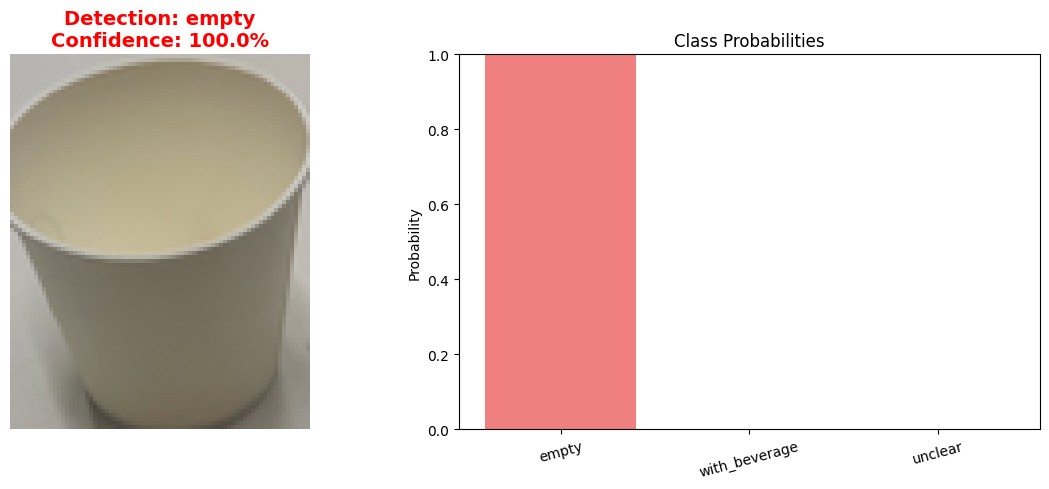


Testing: with_beverage
Image: zf_bottle_309.png
Predicted class: with_beverage
Has beverage: True
Confidence: 85.84%
Probabilities:
  - empty: 0.079
  - with_beverage: 0.858
  - unclear: 0.062


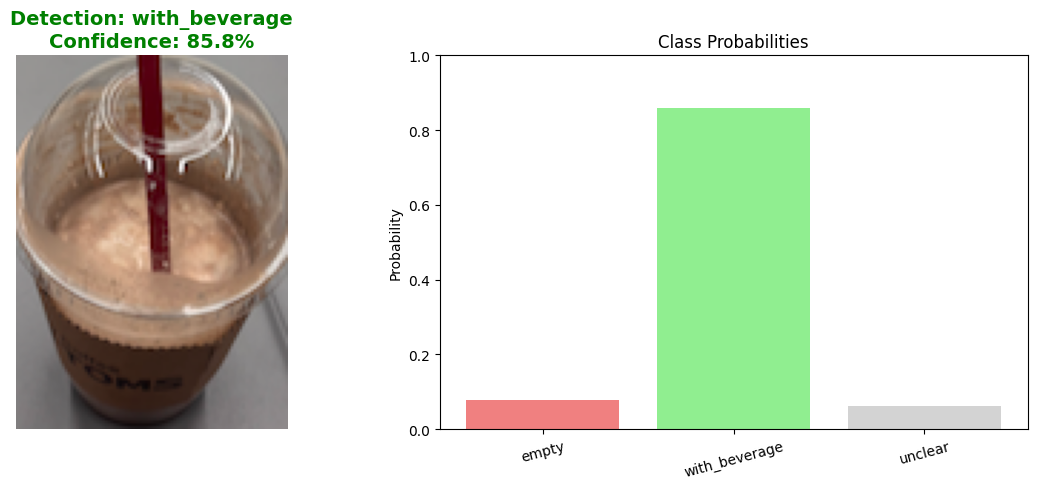


Testing: unclear
Image: zf_bottle_2.png
Predicted class: empty
Has beverage: False
Confidence: 71.41%
Probabilities:
  - empty: 0.714
  - with_beverage: 0.003
  - unclear: 0.283


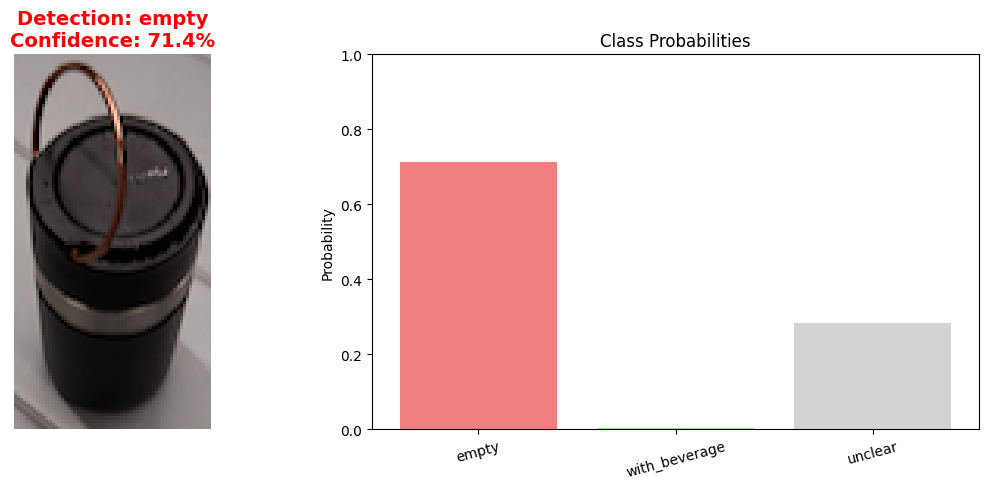

In [17]:
# 검증 세트에서 랜덤 샘플 선택
import random

# 각 클래스별로 샘플 선택
for class_idx, class_name in enumerate(CLASS_NAMES):
    # 해당 클래스의 이미지 찾기
    class_images = [img for img, label in zip(val_images, val_labels) if label == class_idx]
    
    if class_images:
        test_image_path = random.choice(class_images)
        
        print(f"\n{'='*60}")
        print(f"Testing: {class_name}")
        print(f"Image: {os.path.basename(test_image_path)}")
        print(f"{'='*60}")
        
        result = detect_beverage(model, test_image_path, val_transform, device)
        
        print(f"Predicted class: {result['class']}")
        print(f"Has beverage: {result['has_beverage']}")
        print(f"Confidence: {result['confidence']*100:.2f}%")
        print(f"Probabilities:")
        for cls, prob in zip(CLASS_NAMES, result['probabilities']):
            print(f"  - {cls}: {prob:.3f}")
        
        visualize_detection(test_image_path, result)

## 16. 모델 최적화 (선택사항)

In [18]:
# 양자화 (INT8) - 추론 속도 더 향상
model_quantized = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)

# 양자화 모델 저장
quantized_path = MODEL_SAVE_PATH.replace('.pth', '_quantized.pth')
torch.save(model_quantized.state_dict(), quantized_path)

print(f"Quantized model saved: {quantized_path}")

# 크기 비교
original_size = os.path.getsize(MODEL_SAVE_PATH) / (1024 * 1024)  # MB
quantized_size = os.path.getsize(quantized_path) / (1024 * 1024)  # MB

print(f"\nModel size:")
print(f"  Original: {original_size:.2f} MB")
print(f"  Quantized: {quantized_size:.2f} MB")
print(f"  Reduction: {(1 - quantized_size/original_size)*100:.1f}%")

Quantized model saved: ./models/weights/beverage_detector_quantized.pth

Model size:
  Original: 4.24 MB
  Quantized: 3.82 MB
  Reduction: 9.9%


## 17. ONNX 변환

In [19]:
# ONNX 변환 (배포용)
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
onnx_path = MODEL_SAVE_PATH.replace('.pth', '.onnx')

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=11,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"Model exported to ONNX: {onnx_path}")

Model exported to ONNX: ./models/weights/beverage_detector.onnx


## 18. 실전 시나리오 테스트

In [20]:
# 실전 시나리오: 사용 인증 워크플로우
def verify_usage(image_path, model, transform, device, confidence_threshold=0.7):
    """
    사용 인증: 음료가 담겨있으면 통과
    
    Args:
        image_path: 사용 인증 이미지
        model: 학습된 모델
        transform: 전처리
        device: 디바이스
        confidence_threshold: 신뢰도 임계값
    
    Returns:
        dict: 검증 결과
    """
    result = detect_beverage(model, image_path, transform, device)
    
    # 검증 로직
    is_valid = result['has_beverage'] and result['confidence'] >= confidence_threshold
    
    return {
        'is_valid': is_valid,
        'has_beverage': result['has_beverage'],
        'confidence': result['confidence'],
        'message': 'OK' if is_valid else 'Beverage not detected or low confidence'
    }

# 테스트
test_cases = [
    ('./data/usage_test/coffee_tumbler.jpg', '커피 담긴 텀블러'),
    ('./data/usage_test/empty_tumbler.jpg', '빈 텀블러'),
    ('./data/usage_test/water_bottle.jpg', '물 담긴 보틀'),
]

for img_path, description in test_cases:
    if os.path.exists(img_path):
        result = verify_usage(img_path, model, val_transform, device)
        print(f"{description}:")
        print(f"  Valid: {result['is_valid']}")
        print(f"  Has beverage: {result['has_beverage']}")
        print(f"  Confidence: {result['confidence']*100:.2f}%")
        print(f"  Message: {result['message']}")
        print()

## 요약

### 모델 성능
- **최고 검증 정확도**: {best_val_acc:.2f}%
- **추론 속도**: ~{avg_time:.2f}ms (목표 < 100ms)
- **모델 크기**: ~{original_size:.2f}MB

### 검증 기준
- **음료 있음** → ✅ 통과
- **음료 없음** → ❌ 거부
- **신뢰도 임계값**: 0.7 (조정 가능)

### 다음 단계
1. FastAPI 서버에 모델 통합
2. 실전 데이터로 추가 테스트
3. 오분류 케이스 분석 및 개선
4. 모델 최적화 (양자화, ONNX)